# Data Science article recommender

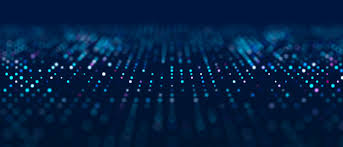

##  <a href='#1'>1. Introduction</a>  
##  <a href='#2'>2. Exploratory Data Analysis (EDA)</a>
## <a id='2'>3. Data Visualization</a>

### <a id='1'>1. Introduction</a>

This project aims to provide relevant articles for users interested in specific data science topics using Natural Language Processing (NLP) techniques with TensorFlow.

It builds a model that suggests a series of articles depending on the user input.

This project combines all the necessary skills for dealing with data:
* Exploratory Data Analysis
* Building Models
* Deploying output to production
* Making it accessible by using a public website

### If you need to contact me, don't be afraid:
* Email: **leonardo.sanchezsoler@gmail.com**
* Linkedin: **https://www.linkedin.com/in/leonardosanchezsoler/**

### Check my repo in Github: **https://github.com/leosanchezsoler**

### <a id='2'>2. Exploratory Data Analysis (EDA)</a>

In [54]:
### Import the necessary libraries ###

# READING FILES
import json # Module for reading json files

# EDA
import pandas as pd # High-performance module for data analysis
import numpy as np # Fundamental package for linear algebra
from src.utils.mining_data_tb import df_info, remove_cols, apply_function_to_cols # Self-made functions

# TEXT FORMATTING 
from ast import literal_eval # convert 'stringfield' lists to usable structure
import re # regex for text formatting and cleaning
from src.utils.text_formatting_tb import get_names, get_link, get_tag, apply_clean_text

# DATA VISUALIZATION
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# DATA PREPROCESSING AND NLP
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk

### Load the dataset

In [55]:
# Assign the url to a variable
df = pd.read_json('https://raw.githubusercontent.com/NeelShah18/arxivData/master/arxivData.json')

# Get DataFrame info to see how the data is structured
df_info(df=df)

####
DATAFRAME INFO
####

Number of rows: 41000
Number of columns: 9

#### DATAFRAME COLUMNS ####
 Index(['author', 'day', 'id', 'link', 'month', 'summary', 'tag', 'title',
       'year'],
      dtype='object') 

### DATAFRAME COLUMN TYPES ###

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41000 entries, 0 to 40999
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   author   41000 non-null  object
 1   day      41000 non-null  int64 
 2   id       41000 non-null  object
 3   link     41000 non-null  object
 4   month    41000 non-null  int64 
 5   summary  41000 non-null  object
 6   tag      41000 non-null  object
 7   title    41000 non-null  object
 8   year     41000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 2.8+ MB

 None

### TOTAL NaN VALUES ###
 author     0
day        0
id         0
link       0
month      0
summary    0
tag        0
title      0
year       0
dtype: int64


In [56]:
# Use df.describe() to show how the data is distributed and tendencies in the columns
df.describe()

,day,month,year
count,41000.000000,41000.000000,41000.000000
mean,15.833293,6.547488,2014.484073
std,8.699371,3.525254,3.685414
min,1.000000,1.000000,1993.000000
25%,8.000000,3.000000,2013.000000
50%,16.000000,6.000000,2016.000000
75%,23.000000,10.000000,2017.000000
max,31.000000,12.000000,2018.000000


In [57]:
# See how data is presented
df.head()

,author,day,id,link,month,summary,tag,title,year
0,"[{'name': 'Ahmed Osman'}, {'name': 'Wojciech S...",1,1802.00209v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",2,We propose an architecture for VQA which utili...,"[{'term': 'cs.AI', 'scheme': 'http://arxiv.org...",Dual Recurrent Attention Units for Visual Ques...,2018
1,"[{'name': 'Ji Young Lee'}, {'name': 'Franck De...",12,1603.03827v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",3,Recent approaches based on artificial neural n...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",Sequential Short-Text Classification with Recu...,2016
2,"[{'name': 'Iulian Vlad Serban'}, {'name': 'Tim...",2,1606.00776v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",6,We introduce the multiresolution recurrent neu...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",Multiresolution Recurrent Neural Networks: An ...,2016
3,"[{'name': 'Sebastian Ruder'}, {'name': 'Joachi...",23,1705.08142v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",5,Multi-task learning is motivated by the observ...,"[{'term': 'stat.ML', 'scheme': 'http://arxiv.o...",Learning what to share between loosely related...,2017
4,"[{'name': 'Iulian V. Serban'}, {'name': 'Chinn...",7,1709.02349v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",9,We present MILABOT: a deep reinforcement learn...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",A Deep Reinforcement Learning Chatbot,2017


In [58]:
# Remove unnecessary columns
cols_list = ['day','id', 'month']
remove_cols(df=df, cols= cols_list)

"The following columns have been removed from your DataFrame: ['day', 'id', 'month']"

### Some of the columns seem to be lists at first sight, but after inspecting them, they behave as strings, so we will have to transform them

In [59]:
# Select the desired columns that will be transdormed
print('Before transforming items:', 'type of author column:', type(df.author[0]))
features = ['author', 'link', 'tag']

apply_function_to_cols(df=df, cols=features, function=literal_eval)

print('Items transformed:', 'type of author column:', type(df.author[0]))

Before transforming items: type of author column: <class 'str'>
Items transformed: type of author column: <class 'list'>


In [60]:
# Use a function that scrapes through html structures

# For names
df['author'] = df['author'].apply(get_names)

# For links
df['link'] = df['link'].apply(get_link)

#For tags
df['tag'] = df['tag'].apply(get_tag)

# Use regex for cleaning the text
cols_to_format = ['title', 'summary']
apply_clean_text(df=df, cols=cols_to_format)

"['title', 'summary'] have been cleaned and formatted"

## Now, our DataFrame is structured the way we wanted

In [61]:
df.head()

,author,link,summary,tag,title,year,clean_title,clean_summary
0,"[Ahmed Osman, Wojciech Samek]",http://arxiv.org/abs/1802.00209v1,We propose an architecture for VQA which utili...,"[cs.AI, cs.CL, cs.CV, cs.NE, stat.ML]",Dual Recurrent Attention Units for Visual Ques...,2018,dual recurrent attention units for visual ques...,we propose an architecture for vqa which utili...
1,"[Ji Young Lee, Franck Dernoncourt]",http://arxiv.org/abs/1603.03827v1,Recent approaches based on artificial neural n...,"[cs.CL, cs.AI, cs.LG, cs.NE, stat.ML]",Sequential Short-Text Classification with Recu...,2016,sequential short text classification with recu...,recent approaches based on artificial neural n...
2,"[Iulian Vlad Serban, Tim Klinger, Gerald Tesauro]",http://arxiv.org/abs/1606.00776v2,We introduce the multiresolution recurrent neu...,"[cs.CL, cs.AI, cs.LG, cs.NE, stat.ML]",Multiresolution Recurrent Neural Networks: An ...,2016,multiresolution recurrent neural networks an a...,we introduce the multiresolution recurrent neu...
3,"[Sebastian Ruder, Joachim Bingel, Isabelle Aug...",http://arxiv.org/abs/1705.08142v2,Multi-task learning is motivated by the observ...,"[stat.ML, cs.AI, cs.CL, cs.LG, cs.NE]",Learning what to share between loosely related...,2017,learning what to share between loosely related...,multi task learning is motivated by the observ...
4,"[Iulian V. Serban, Chinnadhurai Sankar, Mathie...",http://arxiv.org/abs/1709.02349v2,We present MILABOT: a deep reinforcement learn...,"[cs.CL, cs.AI, cs.LG, cs.NE, stat.ML]",A Deep Reinforcement Learning Chatbot,2017,a deep reinforcement learning chatbot,we present milabot a deep reinforcement learni...


### Once the DataFrame is formatted, save it

In [62]:
# Save the dataframe
result = df.to_json('data/data.json', orient='records', indent=4)

In [63]:
def save_freq_words(df, col, terms = 30):
    '''
    @leosanchezsoler
    This function is made to save the most repeated words in a dataset in order to plot them in a wordcloud
    Parameters:
        - df: a pandas DataFrame
        - col: the desired column
        - terms: 

    '''
    all_words = ' '.join([text for text in df[col]])
    all_words = all_words.split()
    
    freq_dist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(freq_dist.keys()), 'count':list(freq_dist.values())})
    words_df.sort_values(by='count', ascending=False, inplace=True)
    words_df.to_json('data/wordcloud.json', indent=4, orient='records')

save_freq_words(df=df, col='soup')

KeyError: 'soup'

In [39]:
# Tokenize and save the most relevant words in order to create a wordcloud with them
max_words = 1000
tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(df.soup)

dictionary = tokenizer.word_index

### <a id='2'>3. Data Visualization</a>
#### In this project, **`words`** are our main source of information, so our visualizations need to reflect the impact they will have on the model that will be trained

- We will create a new column called **soup** that mixes both the title and the summary of the dataframe, the columns with more relevant text in our dataset

In [64]:
df['soup'] = df['clean_title'] + df['clean_summary']
df.soup.head()

0    dual recurrent attention units for visual ques...
1    sequential short text classification with recu...
2    multiresolution recurrent neural networks an a...
3    learning what to share between loosely related...
4    a deep reinforcement learning chatbotwe presen...
Name: soup, dtype: object

In [65]:
def save_freq_words(df, col, terms = 30):
    '''
    @leosanchezsoler
    This function is made to save the most repeated words in a dataset in order to plot them in a wordcloud
    Parameters:
        - df: a pandas DataFrame
        - col: the desired column
        - terms: 

    '''
    all_words = ' '.join([text for text in df[col]])
    all_words = all_words.split()
    
    freq_dist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(freq_dist.keys()), 'count':list(freq_dist.values())})
    words_df.sort_values(by='count', ascending=False, inplace=True)
    words_df.to_json('data/wordcloud.json', indent=4, orient='records')

save_freq_words(df=df, col='soup')

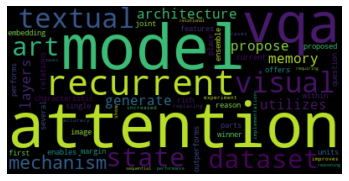

In [30]:
## Let's learn how to use wordcloud

text = df.clean_summary[0]

# Create and generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [38]:
text_title = ''.join(titles for titles in df.clean_title)
text_summary = ''.join(summaries for summaries in df.clean_summary)
text_soup = ''.join(soups for soups in df.soup)
print('There are {} words in the title column'.format(len(text_title)))
print('\nThere are {} words in the summary column'.format(len(text_summary)))
print('\nThere are {} words in the soup column'.format(len(text_soup)))

There are 2785112 words in the title column

There are 41047780 words in the summary column

There are 43832892 words in the soup column


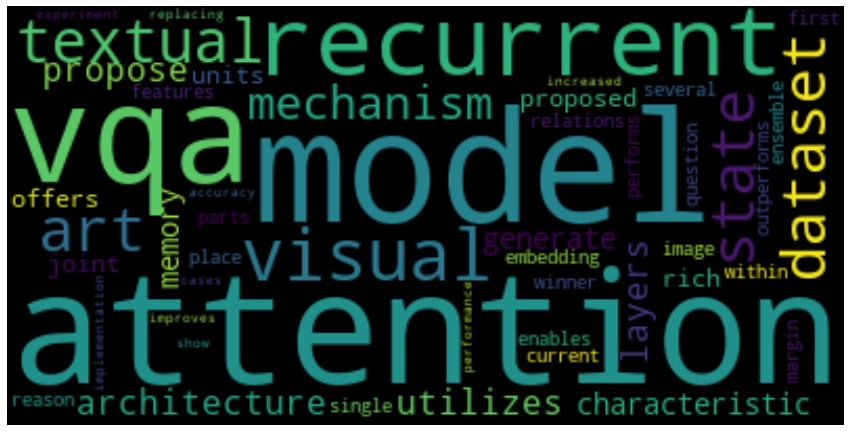

NameError: name 'filename' is not defined

In [31]:
# plot the 100 most frequent words

def create_wordcloud(df, col, max_words, show=False, save=False, filename=None):
    '''
    This function creates a wordmap that contains the desired amount of relevant words coming from a text.
    Parameters:
        - df: a pandas DataFrame
        - col: the column that will be represented
        - max_words: the maximum relevant words
        - show: if True, plot the wordcloud
        - save: if True, save the image 
    '''


plt.figure(figsize=(15,20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_html('static/' + filename + '.html')

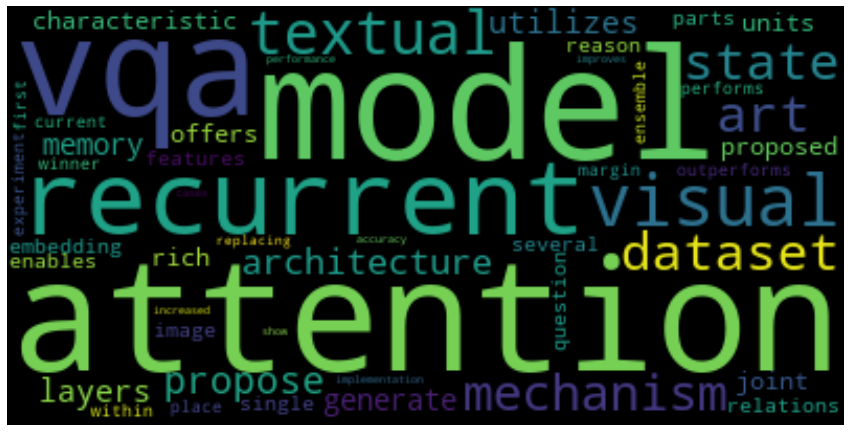

ModuleNotFoundError: No module named 'fontTools'

In [40]:
wordcloud = WordCloud(max_words=50).generate(text)
plt.figure(figsize=(15,20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

filename = 'test1'
path_png = 'documentation/images/static/' + filename + '.png'
path_html = 'documentation/images/html/' + filename + '.html'
wordcloud.to_file(path_png)